In [74]:
# Esta celda actúa sobre la libreta, y permite que se aproveche mejor el espacio.
from IPython.core.display import display, HTML
display(HTML("<style>.container{ width:95%}</style>"))
import sys
print(sys.executable) 
#import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
import seaborn as sns
from sklearn import preprocessing

from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
El codigo Python de este cuaderno está oculto para facilitar la lectura.
Para mostrar/ocultar el código, haz click <a href="javascript:code_toggle()">aquí.</a>.''')

c:\users\48259328\appdata\local\programs\python\python38\python.exe


# Load results

In [75]:
import pandas as pd
df_alg=pd.read_csv('output/merged_output.txt')
display(df_alg.head(2))
convert_dict = {'Dataset': "string", 
                'Algorithm': "string",
                'Population Length': "int64",
                'Generations': "int64",
                'Selection Scheme': "string",
                'Selection Candidates': "int64",
                'Crossover Scheme': "string",
                'Crossover Probability': "float64",
                'Mutation Scheme': "string",
                'Mutation Probability': "float64",
                'Replacement Scheme': "string",
                'Time(s)': "float64",
                'AvgValue': "float64",
                'BestAvgValue': "float64",
                'BestGeneration': "int64",
                'HV': "float64",
                'Spread': "float64",
                'NumSolutions': "float64",
                'Spacing': "float64"
               } 
df_alg = df_alg.astype(convert_dict) 

,Dataset,Algorithm,Population Length,Generations,Selection Scheme,Selection Candidates,Crossover Scheme,Crossover Probability,Mutation Scheme,Mutation Probability,Replacement Scheme,Time(s),AvgValue,BestAvgValue,BestGeneration,HV,Spread,NumSolutions,Spacing
0,dataset2,NSGAIIAlgorithm,30,300,tournament,2,onepoint,0.8,flip1bit,0.2,elitism,182.711253,0.679993,0.824242,296,97975.8,0.918999,23.0,0.153845
1,dataset2,NSGAIIAlgorithm,30,300,tournament,2,onepoint,0.8,flip1bit,0.2,elitism,183.359308,0.636687,0.711111,280,166808.0,0.914188,25.0,0.194882


---
# Helper functions

## Find configurations in a dataframe

In [76]:
def findConfigurationData(df,algorithm):
    return df[(df["Population Length"]==algorithm.p)&(df["Generations"]==algorithm.g)
                     &(df["Selection Scheme"]==algorithm.ss)&(df["Selection Candidates"]==algorithm.sc)
                     &(df["Crossover Scheme"]==algorithm.cs)&(df["Crossover Probability"]==algorithm.cp)
                     &(df["Mutation Scheme"]==algorithm.ms)&(df["Mutation Probability"]==algorithm.mp)
              &(df["Algorithm"]==algorithm.a)&(df["Replacement Scheme"]==algorithm.rs)
              &(df["Dataset"]==algorithm.d)
             ]

## Algorithm config structure

In [77]:
from sklearn import preprocessing
import plotly.graph_objects as go
import plotly.offline as pyo
import math
class AlgorithmData():
    def __init__(self,a,rs,d,p,g,ss,sc,cs,cp,ms,mp):
        self.a=a
        self.rs=rs
        self.d=d
        self.p=p
        self.g=g
        self.ss=ss
        self.sc=sc
        self.cs=cs
        self.cp=cp
        self.ms=ms
        self.mp=mp

## Calculate star chart given an array of configurations and a dataset

In [78]:
import seaborn as sns

def calculateStarChart(algorithms_array,dataset,time_limit,title,onlyResult=False,fileName="fig1.svg",legend=True):
    #algorithm, replacement,dataset,p,g,ss,sc,cs,cp,ms,mp
    df_radar = df_alg.copy(deep=True)
    df_chartdata=pd.DataFrame(columns=df_radar.columns)
    for algorithm in algorithms_array:
        df_star_d1_gnds=findConfigurationData(df_radar,algorithm)
        print("Datos configuracion") if not onlyResult else 0
        display(df_star_d1_gnds.head(5)) if not onlyResult else 0
        df_chartdata=df_chartdata.append(df_star_d1_gnds)
        
    display(df_chartdata.head(5)) if not onlyResult else 0
    
    scaler = preprocessing.MinMaxScaler()
    
    df_radar=df_radar[(df_radar['Dataset']==dataset)]
                
    sns.set_theme(style="whitegrid")
    ax = sns.boxplot(x=df_radar["Time(s)"])
    
    df_radar['Time(s)']=1/df_radar['Time(s)']
    df_radar['Spread']=1/df_radar['Spread']
    
    df_radar['HV'] = scaler.fit_transform(df_radar[['HV']].values.astype(float))
    df_radar['Spread'] = scaler.fit_transform(df_radar[['Spread']].values.astype(float))
    df_radar['Spacing'] = scaler.fit_transform(df_radar[['Spacing']].values.astype(float))
    df_radar['NumSolutions'] = scaler.fit_transform(df_radar[['NumSolutions']].values.astype(float))
    df_radar['AvgValue'] = scaler.fit_transform(df_radar[['AvgValue']].values.astype(float))
    df_radar['Time(s)'] = scaler.fit_transform(df_radar[['Time(s)']].values.astype(float))
    
    print("Datos normalizados") if not onlyResult else 0
    display(df_radar) if not onlyResult else 0

    
    # dibujar grafico
    categories = ['AvgValue', 'NºSols', 'Spacing', '1/Spread','HV']
    categories = [*categories, categories[0]]

    data=[]
    titles=[]
    for algorithm in algorithms_array:
        df_aux=findConfigurationData(df_radar,algorithm)
        df_aux_means=df_aux[['AvgValue','Spread', 'Spacing', 'NumSolutions','HV',]].mean()
        display(df_aux_means) if not onlyResult else 0
        aux_data = list(df_aux_means) 
        aux_data = [*aux_data, aux_data[0]]
        data.append(aux_data)
        titles.append( (algorithm.a+"-"+algorithm.rs) )
        
    markers=["circle","square","diamond"]
    dashes=["solid","dot","dash"]
    titles=["GeneticNDS elitism","GeneticNDS elitismNDS","NSGA-II"]
    fig = go.Figure(
        data=[
            go.Scatterpolar(r=data[x],marker_symbol=markers[x] ,theta=categories, name=titles[x],line_dash=dashes[x]) for x in range(0,len(data))
        ],
        layout=go.Layout(
            polar={'radialaxis': {'visible': True,'showticklabels':False,'range':[0, 1],'showline':False},
                   'angularaxis':{'rotation':90,},
                  },
            showlegend=legend
        )
    )
    fig.update_layout(legend=dict(
        orientation="h",
        yanchor="bottom",
        xanchor="center",
        x=0.5
    ))
    pyo.plot(fig)
    fig.write_image(fileName)

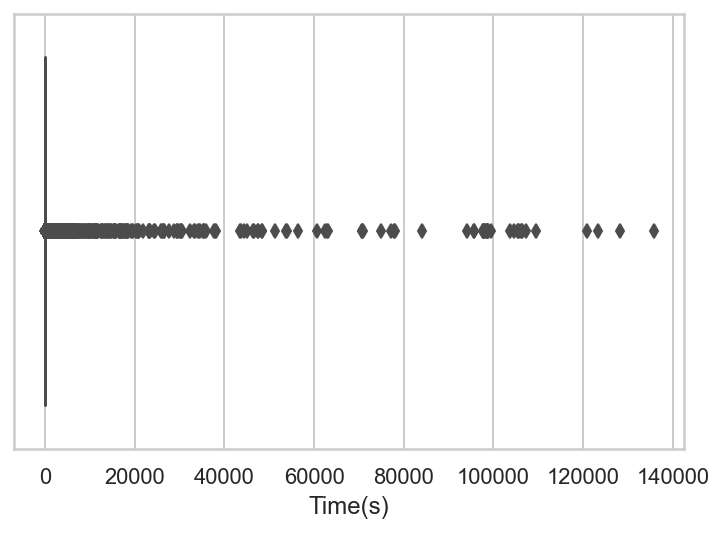

In [79]:
#prueba
algorithm1=AlgorithmData("GeneticNDSAlgorithm",'elitism',"dataset1",20,100,"tournament",2,"onepoint",0.9,"flip1bit",0.05)
algorithm2=AlgorithmData("GeneticNDSAlgorithm",'elitismnds',"dataset1",20,100,"tournament",2,"onepoint",0.9,"flip1bit",0.05)
algorithm3=AlgorithmData("NSGAIIAlgorithm",'elitism',"dataset1",20,100,"tournament",2,"onepoint",0.9,"flip1bit",0.05)
calculateStarChart([algorithm1,algorithm2,algorithm3],"dataset1",120,"title",onlyResult=True)

---
# Best configs for Dataset 1

## Best config for GeneticNDS elitism

In [134]:
algs=[]
dfs=[]
configs=["Algorithm","Population Length","Generations","Selection Scheme","Selection Candidates","Crossover Scheme",'Crossover Probability','Mutation Scheme', 'Mutation Probability']

df_a = df_alg[(df_alg["Algorithm"]=="GeneticNDSAlgorithm")&(df_alg["Dataset"]=="dataset1")&(df_alg["Replacement Scheme"]=="elitism")]
df_a=(
    df_a.groupby(configs)\
    [['Time(s)', 'HV', 'Spread',"AvgValue","BestAvgValue","BestGeneration","NumSolutions","Spacing"]]\
    .agg(mean_time=('Time(s)', 'mean'),
         mean_hv=('HV', 'mean'),
         mean_spread=('Spread', 'mean'),
         mean_avgvalue=('AvgValue', 'mean'),
         mean_bestavgvalue=('BestAvgValue', 'mean'),
         mean_bestgeneration=('BestGeneration', 'mean'),
         mean_numsolutions=('NumSolutions', 'mean'),
         mean_spacing=('Spacing', 'mean'),
        )
    .reset_index()\
    .sort_values("mean_avgvalue",ascending=False)
)
df_a=df_a[df_a["mean_time"]<2*60]
dfs.append(df_a.to_numpy()[0])
display(df_a)
alg=AlgorithmData("GeneticNDSAlgorithm",'elitism',"dataset1",40,200,"tournament",2,"onepoint",0.85,"flip1bit",0.1)
algs.append(alg)
display(findConfigurationData(df_alg,alg))

,Algorithm,Population Length,Generations,Selection Scheme,Selection Candidates,Crossover Scheme,Crossover Probability,Mutation Scheme,Mutation Probability,mean_time,mean_hv,mean_spread,mean_avgvalue,mean_bestavgvalue,mean_bestgeneration,mean_numsolutions,mean_spacing
422,GeneticNDSAlgorithm,40,200,tournament,2,onepoint,0.85,flip1bit,0.10,48.866542,10135.42,0.895336,5.327944,7.075202,114.7,32.1,0.390707
420,GeneticNDSAlgorithm,40,200,tournament,2,onepoint,0.85,flip1bit,0.00,109.370011,9815.78,1.038003,5.297167,6.033651,79.6,32.0,0.412383
478,GeneticNDSAlgorithm,40,300,tournament,2,onepoint,0.85,flip1bit,0.10,105.678809,10841.52,0.929769,5.212603,6.768333,169.9,36.0,0.388344
477,GeneticNDSAlgorithm,40,300,tournament,2,onepoint,0.85,flip1bit,0.05,94.480597,10183.48,0.935473,5.131797,7.018635,164.5,34.0,0.366677
324,GeneticNDSAlgorithm,30,300,tournament,2,onepoint,0.90,flip1bit,0.10,99.163824,10471.80,0.944329,5.105731,7.633333,160.7,32.5,0.358076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54,GeneticNDSAlgorithm,20,100,tournament,2,onepoint,0.90,flipeachbit,0.70,5.974774,10163.52,0.646244,3.494368,5.625110,57.3,32.5,0.269488
12,GeneticNDSAlgorithm,20,100,tournament,2,onepoint,0.60,flipeachbit,0.70,5.272585,9812.24,0.654008,3.492038,5.634286,50.5,28.5,0.274959
10,GeneticNDSAlgorithm,20,100,tournament,2,onepoint,0.60,flipeachbit,0.20,5.127402,9544.46,0.661501,3.479277,6.155556,52.8,26.5,0.254430
208,GeneticNDSAlgorithm,30,100,tournament,2,onepoint,0.85,flipeachbit,0.70,7.071757,9027.00,0.671972,3.467073,5.656135,49.0,30.9,0.256579


,Dataset,Algorithm,Population Length,Generations,Selection Scheme,Selection Candidates,Crossover Scheme,Crossover Probability,Mutation Scheme,Mutation Probability,Replacement Scheme,Time(s),AvgValue,BestAvgValue,BestGeneration,HV,Spread,NumSolutions,Spacing
1647,dataset1,GeneticNDSAlgorithm,40,200,tournament,2,onepoint,0.85,flip1bit,0.1,elitism,24.833710,4.076769,5.090909,179,8528.4,0.750522,27.0,0.390923
1648,dataset1,GeneticNDSAlgorithm,40,200,tournament,2,onepoint,0.85,flip1bit,0.1,elitism,31.125736,4.335373,5.111111,70,8935.2,0.734846,34.0,0.395106
1649,dataset1,GeneticNDSAlgorithm,40,200,tournament,2,onepoint,0.85,flip1bit,0.1,elitism,39.132560,5.443020,6.950000,114,7679.6,0.894483,32.0,0.402825
1650,dataset1,GeneticNDSAlgorithm,40,200,tournament,2,onepoint,0.85,flip1bit,0.1,elitism,54.252893,5.395725,6.950000,19,9585.0,0.922984,33.0,0.368414
1651,dataset1,GeneticNDSAlgorithm,40,200,tournament,2,onepoint,0.85,flip1bit,0.1,elitism,52.630808,5.574706,6.950000,125,9585.0,0.944279,29.0,0.365402
1652,dataset1,GeneticNDSAlgorithm,40,200,tournament,2,onepoint,0.85,flip1bit,0.1,elitism,53.311714,5.535559,6.950000,191,9585.0,0.932369,30.0,0.356751
1653,dataset1,GeneticNDSAlgorithm,40,200,tournament,2,onepoint,0.85,flip1bit,0.1,elitism,55.735121,5.477254,6.950000,80,12090.0,0.898461,33.0,0.398052
1654,dataset1,GeneticNDSAlgorithm,40,200,tournament,2,onepoint,0.85,flip1bit,0.1,elitism,55.719649,5.817775,8.600000,166,12090.0,0.965761,35.0,0.410395
1655,dataset1,GeneticNDSAlgorithm,40,200,tournament,2,onepoint,0.85,flip1bit,0.1,elitism,61.216099,5.788165,8.600000,152,12090.0,0.968750,35.0,0.418542
1656,dataset1,GeneticNDSAlgorithm,40,200,tournament,2,onepoint,0.85,flip1bit,0.1,elitism,60.707125,5.835093,8.600000,51,11186.0,0.940903,33.0,0.400657


## Best config for GeneticNDS elitismNDS

In [135]:
configs=["Algorithm","Population Length","Generations","Selection Scheme","Selection Candidates","Crossover Scheme",'Crossover Probability','Mutation Scheme', 'Mutation Probability']

df_a = df_alg[(df_alg["Algorithm"]=="GeneticNDSAlgorithm")&(df_alg["Dataset"]=="dataset1")&(df_alg["Replacement Scheme"]=="elitismnds")]
df_a=(
    df_a.groupby(configs)\
    [['Time(s)', 'HV', 'Spread',"AvgValue","BestAvgValue","BestGeneration","NumSolutions","Spacing"]]\
    .agg(mean_time=('Time(s)', 'mean'),
         mean_hv=('HV', 'mean'),
         mean_spread=('Spread', 'mean'),
         mean_avgvalue=('AvgValue', 'mean'),
         mean_bestavgvalue=('BestAvgValue', 'mean'),
         mean_bestgeneration=('BestGeneration', 'mean'),
         mean_numsolutions=('NumSolutions', 'mean'),
         mean_spacing=('Spacing', 'mean'),
        )
    .reset_index()\
    .sort_values("mean_avgvalue",ascending=False)
)
df_a=df_a[df_a["mean_time"]<2*60]
dfs.append(df_a.to_numpy()[0])
display(df_a)
alg=AlgorithmData("GeneticNDSAlgorithm",'elitismnds',"dataset1",30,200,"tournament",2,"onepoint",0.9,"flip1bit",0.1)
algs.append(alg)
display(findConfigurationData(df_alg,alg))

,Algorithm,Population Length,Generations,Selection Scheme,Selection Candidates,Crossover Scheme,Crossover Probability,Mutation Scheme,Mutation Probability,mean_time,mean_hv,mean_spread,mean_avgvalue,mean_bestavgvalue,mean_bestgeneration,mean_numsolutions,mean_spacing
268,GeneticNDSAlgorithm,30,200,tournament,2,onepoint,0.90,flip1bit,0.1,107.383800,10442.82,1.085570,7.052803,8.463333,33.4,29.0,0.517560
437,GeneticNDSAlgorithm,40,200,tournament,2,onepoint,0.90,flip1bit,0.2,94.316584,11764.58,1.084402,6.921637,8.255556,29.0,36.0,0.570783
185,GeneticNDSAlgorithm,30,100,tournament,2,onepoint,0.80,flip1bit,0.2,40.724520,10000.92,1.034730,6.599166,8.113651,15.4,29.9,0.511155
100,GeneticNDSAlgorithm,20,200,tournament,2,onepoint,0.90,flip1bit,0.1,111.781082,10533.16,1.242427,6.594968,7.586667,33.5,32.3,0.655689
423,GeneticNDSAlgorithm,40,200,tournament,2,onepoint,0.85,flip1bit,0.2,85.806866,10521.06,0.986156,6.513907,7.925556,25.3,32.3,0.524766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,GeneticNDSAlgorithm,20,200,tournament,2,onepoint,0.60,flipeachbit,0.7,8.922703,7912.64,0.751909,2.721477,3.380765,70.0,18.8,0.199498
124,GeneticNDSAlgorithm,20,300,tournament,2,onepoint,0.60,flipeachbit,0.7,12.753406,9626.16,0.703464,2.704924,3.390520,136.5,20.8,0.218908
11,GeneticNDSAlgorithm,20,100,tournament,2,onepoint,0.60,flipeachbit,0.5,4.379021,7487.32,0.722149,2.687059,3.296163,30.9,18.5,0.230649
67,GeneticNDSAlgorithm,20,200,tournament,2,onepoint,0.60,flipeachbit,0.5,9.252087,9348.22,0.709839,2.685627,3.434143,107.4,22.7,0.235245


,Dataset,Algorithm,Population Length,Generations,Selection Scheme,Selection Candidates,Crossover Scheme,Crossover Probability,Mutation Scheme,Mutation Probability,Replacement Scheme,Time(s),AvgValue,BestAvgValue,BestGeneration,HV,Spread,NumSolutions,Spacing
38176,dataset1,GeneticNDSAlgorithm,30,200,tournament,2,onepoint,0.9,flip1bit,0.1,elitismnds,15.281369,4.482602,7.233333,188,8080.2,0.854128,21.0,0.307577
38177,dataset1,GeneticNDSAlgorithm,30,200,tournament,2,onepoint,0.9,flip1bit,0.1,elitismnds,34.054726,6.204129,8.600000,101,9856.0,0.947955,27.0,0.486119
38178,dataset1,GeneticNDSAlgorithm,30,200,tournament,2,onepoint,0.9,flip1bit,0.1,elitismnds,44.156556,6.490378,8.600000,4,9856.0,0.896921,28.0,0.551754
38179,dataset1,GeneticNDSAlgorithm,30,200,tournament,2,onepoint,0.9,flip1bit,0.1,elitismnds,51.572842,7.043154,8.600000,1,9856.0,0.993785,29.0,0.571016
38180,dataset1,GeneticNDSAlgorithm,30,200,tournament,2,onepoint,0.9,flip1bit,0.1,elitismnds,74.959609,7.271964,8.600000,5,11130.0,1.028943,32.0,0.586775
38181,dataset1,GeneticNDSAlgorithm,30,200,tournament,2,onepoint,0.9,flip1bit,0.1,elitismnds,92.705830,7.511341,8.600000,3,11130.0,1.090900,30.0,0.581626
38182,dataset1,GeneticNDSAlgorithm,30,200,tournament,2,onepoint,0.9,flip1bit,0.1,elitismnds,128.738079,7.739042,8.600000,11,11130.0,1.180781,30.0,0.556660
38183,dataset1,GeneticNDSAlgorithm,30,200,tournament,2,onepoint,0.9,flip1bit,0.1,elitismnds,172.526124,7.902305,8.600000,4,11130.0,1.262294,29.0,0.516421
38184,dataset1,GeneticNDSAlgorithm,30,200,tournament,2,onepoint,0.9,flip1bit,0.1,elitismnds,213.533404,7.924350,8.600000,2,11130.0,1.289925,31.0,0.514308
38185,dataset1,GeneticNDSAlgorithm,30,200,tournament,2,onepoint,0.9,flip1bit,0.1,elitismnds,246.309464,7.958762,8.600000,15,11130.0,1.310067,33.0,0.503346


## Best config for NSGA-II elitism

In [136]:
configs=["Algorithm","Population Length","Generations","Selection Scheme","Selection Candidates","Crossover Scheme",'Crossover Probability','Mutation Scheme', 'Mutation Probability']

df_a = df_alg[(df_alg["Algorithm"]=="NSGAIIAlgorithm")&(df_alg["Dataset"]=="dataset1")&(df_alg["Replacement Scheme"]=="elitism")]
df_a=(
    df_a.groupby(configs)\
    [['Time(s)', 'HV', 'Spread',"AvgValue","BestAvgValue","BestGeneration","NumSolutions","Spacing"]]\
    .agg(mean_time=('Time(s)', 'mean'),
         mean_hv=('HV', 'mean'),
         mean_spread=('Spread', 'mean'),
         mean_avgvalue=('AvgValue', 'mean'),
         mean_bestavgvalue=('BestAvgValue', 'mean'),
         mean_bestgeneration=('BestGeneration', 'mean'),
         mean_numsolutions=('NumSolutions', 'mean'),
         mean_spacing=('Spacing', 'mean'),
        )
    .reset_index()\
    .sort_values("mean_avgvalue",ascending=False)
)
df_a=df_a[df_a["mean_time"]<2*60]
dfs.append(df_a.to_numpy()[0])
display(df_a)
alg=AlgorithmData("NSGAIIAlgorithm",'elitism',"dataset1",40,300,"tournament",2,"onepoint",0.85,"flip1bit",1)
algs.append(alg)
display(findConfigurationData(df_alg,alg))

,Algorithm,Population Length,Generations,Selection Scheme,Selection Candidates,Crossover Scheme,Crossover Probability,Mutation Scheme,Mutation Probability,mean_time,mean_hv,mean_spread,mean_avgvalue,mean_bestavgvalue,mean_bestgeneration,mean_numsolutions,mean_spacing
482,NSGAIIAlgorithm,40,300,tournament,2,onepoint,0.85,flip1bit,1.0,75.466311,14936.96,0.929038,4.406016,8.600000,133.5,33.8,0.432767
454,NSGAIIAlgorithm,40,300,tournament,2,onepoint,0.60,flip1bit,1.0,72.326034,15181.00,0.929506,4.401556,8.600000,61.0,32.8,0.450985
411,NSGAIIAlgorithm,40,200,tournament,2,onepoint,0.80,flip1bit,0.7,47.539558,14706.36,0.930110,4.389455,8.513333,124.0,30.8,0.430122
457,NSGAIIAlgorithm,40,300,tournament,2,onepoint,0.60,flipeachbit,0.1,70.841535,14814.94,0.929579,4.387516,8.526667,125.3,31.4,0.434639
398,NSGAIIAlgorithm,40,200,tournament,2,onepoint,0.60,flip1bit,1.0,48.250409,15181.00,0.929470,4.386814,8.600000,49.4,33.5,0.450245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41,NSGAIIAlgorithm,20,100,tournament,2,onepoint,0.85,flipeachbit,1.0,8.713334,8241.26,0.861842,3.193112,4.614379,40.1,19.0,0.292710
13,NSGAIIAlgorithm,20,100,tournament,2,onepoint,0.60,flipeachbit,1.0,8.204858,8470.54,0.864214,3.162880,4.523922,45.9,17.9,0.317212
49,NSGAIIAlgorithm,20,100,tournament,2,onepoint,0.90,flipeachbit,0.0,8.900513,8233.34,0.869743,3.157730,4.752015,24.7,16.5,0.305204
0,NSGAIIAlgorithm,20,100,tournament,2,onepoint,0.60,flip1bit,0.0,7.911072,7384.22,0.873348,3.145448,4.541257,38.9,14.8,0.292543


,Dataset,Algorithm,Population Length,Generations,Selection Scheme,Selection Candidates,Crossover Scheme,Crossover Probability,Mutation Scheme,Mutation Probability,Replacement Scheme,Time(s),AvgValue,BestAvgValue,BestGeneration,HV,Spread,NumSolutions,Spacing
36028,dataset1,NSGAIIAlgorithm,40,300,tournament,2,onepoint,0.85,flip1bit,1.0,elitism,76.065461,4.353664,8.6,75,15181.0,0.928791,35.0,0.449498
36029,dataset1,NSGAIIAlgorithm,40,300,tournament,2,onepoint,0.85,flip1bit,1.0,elitism,75.551910,4.567298,8.6,64,13960.8,0.930431,32.0,0.408847
36030,dataset1,NSGAIIAlgorithm,40,300,tournament,2,onepoint,0.85,flip1bit,1.0,elitism,75.150370,4.389155,8.6,195,15181.0,0.929125,32.0,0.444733
36031,dataset1,NSGAIIAlgorithm,40,300,tournament,2,onepoint,0.85,flip1bit,1.0,elitism,75.512173,4.377327,8.6,211,15181.0,0.929243,33.0,0.423136
36032,dataset1,NSGAIIAlgorithm,40,300,tournament,2,onepoint,0.85,flip1bit,1.0,elitism,76.359754,4.407344,8.6,154,13960.8,0.930104,33.0,0.387997
36033,dataset1,NSGAIIAlgorithm,40,300,tournament,2,onepoint,0.85,flip1bit,1.0,elitism,75.587582,4.399742,8.6,103,15181.0,0.926453,35.0,0.415061
36034,dataset1,NSGAIIAlgorithm,40,300,tournament,2,onepoint,0.85,flip1bit,1.0,elitism,75.280101,4.376688,8.6,164,15181.0,0.929731,34.0,0.450020
36035,dataset1,NSGAIIAlgorithm,40,300,tournament,2,onepoint,0.85,flip1bit,1.0,elitism,75.038008,4.437957,8.6,135,15181.0,0.929367,35.0,0.457241
36036,dataset1,NSGAIIAlgorithm,40,300,tournament,2,onepoint,0.85,flip1bit,1.0,elitism,75.282849,4.384060,8.6,110,15181.0,0.928964,36.0,0.448838
36037,dataset1,NSGAIIAlgorithm,40,300,tournament,2,onepoint,0.85,flip1bit,1.0,elitism,74.834906,4.366929,8.6,124,15181.0,0.928171,33.0,0.442300


## Wilcoxon Test

In [153]:
cols=["AvgValue","HV","Spread","Spacing","NumSolutions","BestGeneration"]

results=list()
best_avg=0
best_alg_index=None
#results.append("Métrica AvgValue")
for i in range(len(algs)):
    avg=np.mean((findConfigurationData(df_alg,algs[i])[cols])["AvgValue"].values)
    results.append("{:.3f}".format(avg))
    if avg>best_avg:
        best_avg=avg
        best_alg_index=i

p_best=True
for i in range(len(algs)):
    if i!=best_alg_index:
        dataA=(findConfigurationData(df_alg,algs[best_alg_index])[cols])["AvgValue"].values
        dataB=(findConfigurationData(df_alg,algs[i])[cols])["AvgValue"].values
        _, p = ranksums(dataA, dataB)
        print(p)
        if p>=0.05:
            p_best=False
        
if p_best:
    mark = '*'
else:
    mark = ''
results[best_alg_index]=results[best_alg_index]+mark
results.insert(0,"AvgValue")
print(results)
    

0.001498873337151676
0.00021218287122257823
['AvgValue', '5.328', '7.053*', '4.406']


In [177]:
cols=["AvgValue","HV","Spread","Spacing","NumSolutions","BestGeneration"]
maxmin=[1,1,-1,1,1,1]

for j in range(len(cols)): 
    print(cols[j])
    results=list()
    best_avg=0
    best_avgn=10**9
    best_alg_index=None
    for i in range(len(algs)):
        avg=np.mean((findConfigurationData(df_alg,algs[i])[cols])[cols[j]].values)
        results.append("{:.3f}".format(avg))
        if maxmin[j]>0 and avg>best_avg:
            best_avg=avg
            best_alg_index=i
        elif maxmin[j]<0 and avg<best_avgn:
            best_avgn=avg
            best_alg_index=i

    p_best=True
    p_list=[]
    for i in range(len(algs)):
        if i!=best_alg_index:
            dataA=(findConfigurationData(df_alg,algs[best_alg_index])[cols])[cols[j]].values
            dataB=(findConfigurationData(df_alg,algs[i])[cols])[cols[j]].values
            _, p = ranksums(dataA, dataB)
            print("p:",p)
            if p>=0.05:
                #print(dataA)
                #print(dataB)
                p_best=False
            else:
                p_list.append(i)

    if p_best:
        mark = '*'
    else:
        mark = ''
    for index in p_list:
        results[index]=results[index]+'-'
    #results[best_alg_index]=results[best_alg_index]+mark
    results.insert(0,cols[j])
    print(results)
    

AvgValue
p: 0.001498873337151676
p: 0.00021218287122257823
['AvgValue', '5.328-', '7.053', '4.406-']
HV
p: 0.00015705228423075119
p: 0.00015705228423075119
['HV', '10135.420-', '10442.820-', '14936.960']
Spread
p: 0.012611144099313947
p: 1.0
['Spread', '0.895', '1.086-', '0.929']
Spacing
p: 0.002496908915141548
p: 0.002496908915141548
['Spacing', '0.391-', '0.518', '0.433-']
NumSolutions
p: 0.17361733442494354
p: 0.0005828399431792743
['NumSolutions', '32.100', '29.000-', '33.800']
BestGeneration
p: 0.5453496680111236
p: 0.002496908915141548
['BestGeneration', '114.700', '33.400-', '133.500']


## Generate Star Chart

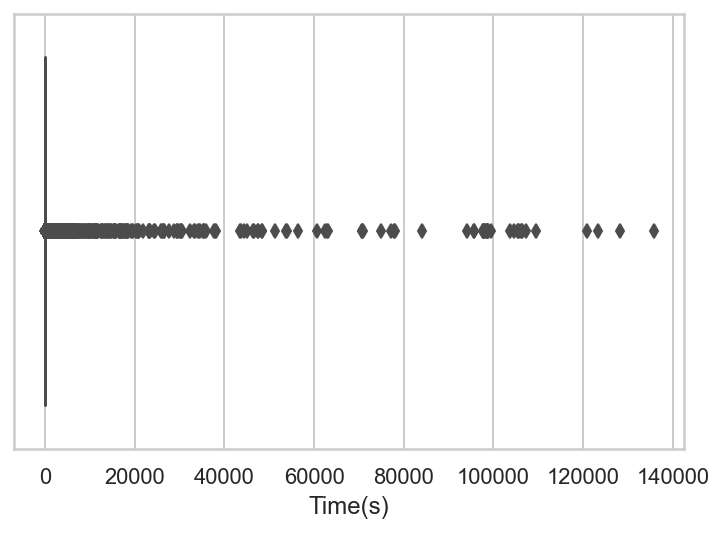

In [83]:
calculateStarChart(algs,"dataset1",time_limit,"Dataset 1",onlyResult=True,fileName="plots/dataset1_star.svg")

---
# Dataset 2

## Best config for GeneticNDS elitism

In [84]:
algs2=[]

configs=["Algorithm","Population Length","Generations","Selection Scheme","Selection Candidates","Crossover Scheme",'Crossover Probability','Mutation Scheme', 'Mutation Probability']

df_a = df_alg[(df_alg["Algorithm"]=="GeneticNDSAlgorithm")&(df_alg["Dataset"]=="dataset2")&(df_alg["Replacement Scheme"]=="elitism")]
df_a=(
    df_a.groupby(configs)\
    [['Time(s)', 'HV', 'Spread',"AvgValue","BestAvgValue","BestGeneration","NumSolutions","Spacing"]]\
    .agg(mean_time=('Time(s)', 'mean'),
         mean_hv=('HV', 'mean'),
         mean_spread=('Spread', 'mean'),
         mean_avgvalue=('AvgValue', 'mean'),
         mean_bestavgvalue=('BestAvgValue', 'mean'),
         mean_bestgeneration=('BestGeneration', 'mean'),
         mean_numsolutions=('NumSolutions', 'mean'),
         mean_spacing=('Spacing', 'mean'),
        )
    .reset_index()\
    .sort_values("mean_avgvalue",ascending=False)
)
df_a=df_a[df_a["mean_time"]<2*60]
display(df_a)
alg=AlgorithmData("GeneticNDSAlgorithm",'elitism',"dataset2",20,200,"tournament",2,"onepoint",0.9,"flip1bit",0.7)
algs2.append(alg)
display(findConfigurationData(df_alg,alg))

,Algorithm,Population Length,Generations,Selection Scheme,Selection Candidates,Crossover Scheme,Crossover Probability,Mutation Scheme,Mutation Probability,mean_time,mean_hv,mean_spread,mean_avgvalue,mean_bestavgvalue,mean_bestgeneration,mean_numsolutions,mean_spacing
103,GeneticNDSAlgorithm,20,200,tournament,2,onepoint,0.90,flip1bit,0.70,69.343440,86261.54,0.835299,0.692515,0.763234,124.8,35.0,0.132637
199,GeneticNDSAlgorithm,30,100,tournament,2,onepoint,0.85,flip1bit,0.20,89.314570,80327.00,0.871467,0.687205,0.754823,63.0,39.3,0.101931
355,GeneticNDSAlgorithm,40,100,tournament,2,onepoint,0.80,flip1bit,0.70,59.100981,90465.68,0.878717,0.686574,0.767055,66.8,39.2,0.109742
162,GeneticNDSAlgorithm,20,300,tournament,2,onepoint,0.90,flipeachbit,0.05,77.899989,79805.80,0.687625,0.684516,0.758362,142.2,33.5,0.125996
17,GeneticNDSAlgorithm,20,100,tournament,2,onepoint,0.80,flip1bit,0.20,74.679531,88127.06,0.968191,0.683103,0.726535,52.3,32.6,0.095864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,GeneticNDSAlgorithm,20,200,tournament,2,onepoint,0.80,flipeachbit,0.70,62.224787,84193.80,0.641129,0.639670,0.717233,94.9,39.2,0.122036
223,GeneticNDSAlgorithm,30,100,tournament,2,onepoint,0.90,flipeachbit,1.00,33.853267,82456.60,0.657344,0.639352,0.708451,40.3,33.8,0.120505
206,GeneticNDSAlgorithm,30,100,tournament,2,onepoint,0.85,flipeachbit,0.20,34.674581,95527.30,0.652451,0.637833,0.732014,38.8,37.5,0.121266
13,GeneticNDSAlgorithm,20,100,tournament,2,onepoint,0.60,flipeachbit,1.00,41.167724,115246.90,0.805007,0.634717,0.704633,46.3,36.6,0.134310


,Dataset,Algorithm,Population Length,Generations,Selection Scheme,Selection Candidates,Crossover Scheme,Crossover Probability,Mutation Scheme,Mutation Probability,Replacement Scheme,Time(s),AvgValue,BestAvgValue,BestGeneration,HV,Spread,NumSolutions,Spacing
31483,dataset2,GeneticNDSAlgorithm,20,200,tournament,2,onepoint,0.9,flip1bit,0.7,elitism,55.835843,0.667665,0.705092,195,78234.0,0.783912,36.0,0.087141
31484,dataset2,GeneticNDSAlgorithm,20,200,tournament,2,onepoint,0.9,flip1bit,0.7,elitism,71.142112,0.689275,0.748227,111,75945.6,0.881229,34.0,0.104577
31485,dataset2,GeneticNDSAlgorithm,20,200,tournament,2,onepoint,0.9,flip1bit,0.7,elitism,74.038321,0.690641,0.748227,140,64396.2,0.880924,37.0,0.094866
31486,dataset2,GeneticNDSAlgorithm,20,200,tournament,2,onepoint,0.9,flip1bit,0.7,elitism,82.802755,0.700449,0.757252,162,88696.4,0.839978,29.0,0.146986
31487,dataset2,GeneticNDSAlgorithm,20,200,tournament,2,onepoint,0.9,flip1bit,0.7,elitism,62.148796,0.694929,0.757252,81,88696.4,0.860049,33.0,0.151206
31488,dataset2,GeneticNDSAlgorithm,20,200,tournament,2,onepoint,0.9,flip1bit,0.7,elitism,70.362058,0.693320,0.757252,123,88696.4,0.849222,38.0,0.145491
31489,dataset2,GeneticNDSAlgorithm,20,200,tournament,2,onepoint,0.9,flip1bit,0.7,elitism,69.948573,0.699839,0.789759,78,88696.4,0.833827,34.0,0.146783
31490,dataset2,GeneticNDSAlgorithm,20,200,tournament,2,onepoint,0.9,flip1bit,0.7,elitism,66.881689,0.696414,0.789759,61,96418.0,0.821940,35.0,0.151103
31491,dataset2,GeneticNDSAlgorithm,20,200,tournament,2,onepoint,0.9,flip1bit,0.7,elitism,68.588568,0.696478,0.789759,136,96418.0,0.792161,37.0,0.148319
31492,dataset2,GeneticNDSAlgorithm,20,200,tournament,2,onepoint,0.9,flip1bit,0.7,elitism,71.685690,0.696144,0.789759,161,96418.0,0.809745,37.0,0.149899


## Best config for GeneticNDS elitismNDS

In [85]:
configs=["Algorithm","Population Length","Generations","Selection Scheme","Selection Candidates","Crossover Scheme",'Crossover Probability','Mutation Scheme', 'Mutation Probability']

df_a = df_alg[(df_alg["Algorithm"]=="GeneticNDSAlgorithm")&(df_alg["Dataset"]=="dataset2")&(df_alg["Replacement Scheme"]=="elitismnds")]
df_a=(
    df_a.groupby(configs)\
    [['Time(s)', 'HV', 'Spread',"AvgValue","BestAvgValue","BestGeneration","NumSolutions","Spacing"]]\
    .agg(mean_time=('Time(s)', 'mean'),
         mean_hv=('HV', 'mean'),
         mean_spread=('Spread', 'mean'),
         mean_avgvalue=('AvgValue', 'mean'),
         mean_bestavgvalue=('BestAvgValue', 'mean'),
         mean_bestgeneration=('BestGeneration', 'mean'),
         mean_numsolutions=('NumSolutions', 'mean'),
         mean_spacing=('Spacing', 'mean'),
        )
    .reset_index()\
    .sort_values("mean_avgvalue",ascending=False)
)
df_a=df_a[df_a["mean_time"]<2*60]
display(df_a)
alg=AlgorithmData("GeneticNDSAlgorithm",'elitismnds',"dataset2",20,100,"tournament",2,"onepoint",0.6,"flip1bit",0.7)
algs2.append(alg)
display(findConfigurationData(df_alg,alg))

,Algorithm,Population Length,Generations,Selection Scheme,Selection Candidates,Crossover Scheme,Crossover Probability,Mutation Scheme,Mutation Probability,mean_time,mean_hv,mean_spread,mean_avgvalue,mean_bestavgvalue,mean_bestgeneration,mean_numsolutions,mean_spacing
5,GeneticNDSAlgorithm,20,100,tournament,2,onepoint,0.6,flip1bit,0.7,89.778743,102698.88,0.911206,0.843217,1.121311,64.9,55.0,0.171797
173,GeneticNDSAlgorithm,30,100,tournament,2,onepoint,0.6,flip1bit,0.7,118.694994,137184.42,0.942564,0.837819,1.145936,59.8,66.4,0.176887
186,GeneticNDSAlgorithm,30,100,tournament,2,onepoint,0.8,flip1bit,0.5,84.363039,114398.90,0.835017,0.794883,0.998757,65.6,50.3,0.197656
76,GeneticNDSAlgorithm,20,200,tournament,2,onepoint,0.8,flip1bit,1.0,83.261863,117657.62,0.754125,0.789779,1.062897,94.0,46.4,0.202552
244,GeneticNDSAlgorithm,30,200,tournament,2,onepoint,0.8,flip1bit,1.0,104.299254,114460.22,0.862646,0.789766,0.998812,119.5,45.0,0.195896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,GeneticNDSAlgorithm,20,300,tournament,2,onepoint,0.6,flipeachbit,0.7,76.118034,67204.56,0.726391,0.596931,0.622822,167.1,30.4,0.098203
291,GeneticNDSAlgorithm,30,300,tournament,2,onepoint,0.6,flipeachbit,0.5,99.278090,104269.22,0.703613,0.595822,0.639249,144.8,34.0,0.126618
123,GeneticNDSAlgorithm,20,300,tournament,2,onepoint,0.6,flipeachbit,0.5,72.402862,99464.20,0.738990,0.595627,0.631086,152.7,28.8,0.104431
12,GeneticNDSAlgorithm,20,100,tournament,2,onepoint,0.6,flipeachbit,0.7,23.157757,79302.68,0.756844,0.595176,0.628319,65.7,28.7,0.112421


,Dataset,Algorithm,Population Length,Generations,Selection Scheme,Selection Candidates,Crossover Scheme,Crossover Probability,Mutation Scheme,Mutation Probability,Replacement Scheme,Time(s),AvgValue,BestAvgValue,BestGeneration,HV,Spread,NumSolutions,Spacing
25338,dataset2,GeneticNDSAlgorithm,20,100,tournament,2,onepoint,0.6,flip1bit,0.7,elitismnds,29.529603,0.669826,0.756403,77,64200.0,0.860158,32.0,0.107884
25339,dataset2,GeneticNDSAlgorithm,20,100,tournament,2,onepoint,0.6,flip1bit,0.7,elitismnds,55.366737,0.758634,0.928980,66,68842.2,0.823448,46.0,0.146330
25340,dataset2,GeneticNDSAlgorithm,20,100,tournament,2,onepoint,0.6,flip1bit,0.7,elitismnds,79.922859,0.805571,1.029744,39,95642.0,0.875042,54.0,0.159628
25341,dataset2,GeneticNDSAlgorithm,20,100,tournament,2,onepoint,0.6,flip1bit,0.7,elitismnds,89.302949,0.812497,1.034225,88,96033.6,0.864333,57.0,0.162090
25342,dataset2,GeneticNDSAlgorithm,20,100,tournament,2,onepoint,0.6,flip1bit,0.7,elitismnds,104.791048,0.881683,1.265693,60,110201.6,0.931220,63.0,0.191021
25343,dataset2,GeneticNDSAlgorithm,20,100,tournament,2,onepoint,0.6,flip1bit,0.7,elitismnds,118.409160,0.879178,1.214570,64,105300.0,0.949730,60.0,0.182772
25344,dataset2,GeneticNDSAlgorithm,20,100,tournament,2,onepoint,0.6,flip1bit,0.7,elitismnds,103.965165,0.864901,1.153103,28,107829.6,0.938231,51.0,0.161735
25345,dataset2,GeneticNDSAlgorithm,20,100,tournament,2,onepoint,0.6,flip1bit,0.7,elitismnds,87.117381,0.875634,1.205634,87,108284.0,0.959226,57.0,0.171375
25346,dataset2,GeneticNDSAlgorithm,20,100,tournament,2,onepoint,0.6,flip1bit,0.7,elitismnds,107.191453,0.938546,1.271698,86,133735.2,0.942177,67.0,0.221587
25347,dataset2,GeneticNDSAlgorithm,20,100,tournament,2,onepoint,0.6,flip1bit,0.7,elitismnds,122.191073,0.945703,1.353061,54,136920.6,0.968493,63.0,0.213553


## Best config for NSGA-II elitism

In [86]:
configs=["Algorithm","Population Length","Generations","Selection Scheme","Selection Candidates","Crossover Scheme",'Crossover Probability','Mutation Scheme', 'Mutation Probability']

df_a = df_alg[(df_alg["Algorithm"]=="NSGAIIAlgorithm")&(df_alg["Dataset"]=="dataset2")&(df_alg["Replacement Scheme"]=="elitism")]
df_a=(
    df_a.groupby(configs)\
    [['Time(s)', 'HV', 'Spread',"AvgValue","BestAvgValue","BestGeneration","NumSolutions","Spacing"]]\
    .agg(mean_time=('Time(s)', 'mean'),
         mean_hv=('HV', 'mean'),
         mean_spread=('Spread', 'mean'),
         mean_avgvalue=('AvgValue', 'mean'),
         mean_bestavgvalue=('BestAvgValue', 'mean'),
         mean_bestgeneration=('BestGeneration', 'mean'),
         mean_numsolutions=('NumSolutions', 'mean'),
         mean_spacing=('Spacing', 'mean'),
        )
    .reset_index()\
    .sort_values("mean_avgvalue",ascending=False)
)
df_a=df_a[df_a["mean_time"]<2*60]
display(df_a)
alg=AlgorithmData("NSGAIIAlgorithm",'elitism',"dataset2",30,200,"tournament",2,"onepoint",0.6,"flipeachbit",0.05)
algs2.append(alg)
display(findConfigurationData(df_alg,alg))

,Algorithm,Population Length,Generations,Selection Scheme,Selection Candidates,Crossover Scheme,Crossover Probability,Mutation Scheme,Mutation Probability,mean_time,mean_hv,mean_spread,mean_avgvalue,mean_bestavgvalue,mean_bestgeneration,mean_numsolutions,mean_spacing
232,NSGAIIAlgorithm,30,200,tournament,2,onepoint,0.6,flipeachbit,0.05,119.331309,240957.72,0.912400,0.763685,1.023609,174.7,30.0,0.246449
344,NSGAIIAlgorithm,40,100,tournament,2,onepoint,0.6,flipeachbit,0.05,92.794820,197216.58,0.930945,0.761239,0.967459,87.2,39.9,0.228431
345,NSGAIIAlgorithm,40,100,tournament,2,onepoint,0.6,flipeachbit,0.10,96.372329,153073.82,0.928926,0.720462,0.858974,79.7,40.0,0.188230
120,NSGAIIAlgorithm,20,300,tournament,2,onepoint,0.6,flipeachbit,0.05,94.548945,278220.06,0.874870,0.717623,0.962537,206.4,20.0,0.272840
176,NSGAIIAlgorithm,30,100,tournament,2,onepoint,0.6,flipeachbit,0.05,59.575032,182883.92,0.911989,0.717514,0.869816,85.9,30.0,0.203471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,NSGAIIAlgorithm,20,100,tournament,2,onepoint,0.8,flipeachbit,1.00,33.762088,76360.54,0.887520,0.616731,0.686652,61.5,18.8,0.134198
7,NSGAIIAlgorithm,20,100,tournament,2,onepoint,0.6,flipeachbit,0.00,32.570738,60162.22,0.894757,0.615395,0.673178,47.1,14.7,0.122407
0,NSGAIIAlgorithm,20,100,tournament,2,onepoint,0.6,flip1bit,0.00,33.749967,67782.04,0.891553,0.615337,0.680193,46.5,14.7,0.135915
4,NSGAIIAlgorithm,20,100,tournament,2,onepoint,0.6,flip1bit,0.50,32.059992,144038.76,0.885086,0.613530,0.692767,68.6,19.2,0.185775


,Dataset,Algorithm,Population Length,Generations,Selection Scheme,Selection Candidates,Crossover Scheme,Crossover Probability,Mutation Scheme,Mutation Probability,Replacement Scheme,Time(s),AvgValue,BestAvgValue,BestGeneration,HV,Spread,NumSolutions,Spacing
1617,dataset2,NSGAIIAlgorithm,30,200,tournament,2,onepoint,0.6,flipeachbit,0.05,elitism,117.526425,0.753928,1.007018,174,289924.8,0.913921,30.0,0.273945
1618,dataset2,NSGAIIAlgorithm,30,200,tournament,2,onepoint,0.6,flipeachbit,0.05,elitism,119.320344,0.753672,1.027219,162,228140.8,0.911157,30.0,0.226570
1619,dataset2,NSGAIIAlgorithm,30,200,tournament,2,onepoint,0.6,flipeachbit,0.05,elitism,119.776915,0.747291,1.013986,188,236350.0,0.906211,30.0,0.228867
1620,dataset2,NSGAIIAlgorithm,30,200,tournament,2,onepoint,0.6,flipeachbit,0.05,elitism,120.886916,0.764827,1.062745,179,251810.0,0.914447,30.0,0.256489
1621,dataset2,NSGAIIAlgorithm,30,200,tournament,2,onepoint,0.6,flipeachbit,0.05,elitism,119.659901,0.774156,1.016049,199,216464.6,0.913469,30.0,0.238972
1622,dataset2,NSGAIIAlgorithm,30,200,tournament,2,onepoint,0.6,flipeachbit,0.05,elitism,120.912238,0.755535,0.921339,113,252814.2,0.909509,30.0,0.231542
1623,dataset2,NSGAIIAlgorithm,30,200,tournament,2,onepoint,0.6,flipeachbit,0.05,elitism,118.739988,0.755790,1.048588,184,205504.0,0.914109,30.0,0.221487
1624,dataset2,NSGAIIAlgorithm,30,200,tournament,2,onepoint,0.6,flipeachbit,0.05,elitism,119.479214,0.787499,1.106557,199,250500.0,0.914660,30.0,0.276106
1625,dataset2,NSGAIIAlgorithm,30,200,tournament,2,onepoint,0.6,flipeachbit,0.05,elitism,117.826981,0.771619,1.071053,172,262305.0,0.911915,30.0,0.266763
1626,dataset2,NSGAIIAlgorithm,30,200,tournament,2,onepoint,0.6,flipeachbit,0.05,elitism,119.184172,0.772538,0.961538,177,215763.8,0.914602,30.0,0.243747


## Generate Star Chart

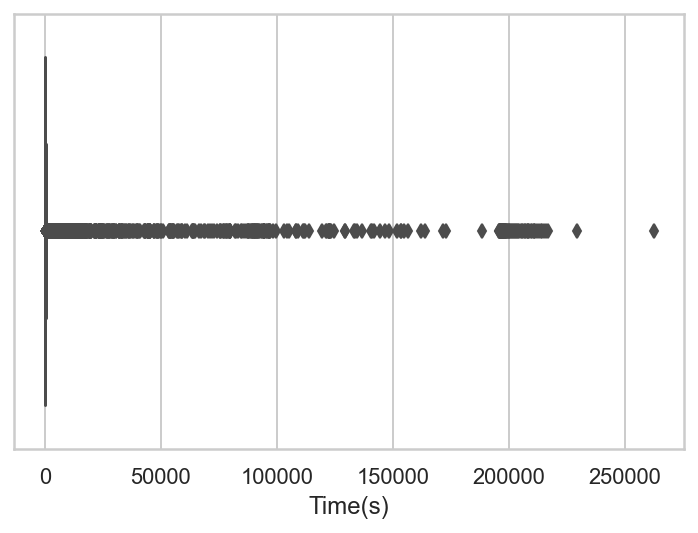

In [87]:
calculateStarChart(algs2,"dataset2",time_limit,"Dataset 2",onlyResult=True,fileName="plots/dataset2_star.svg")

## Generate both star charts with shared legend

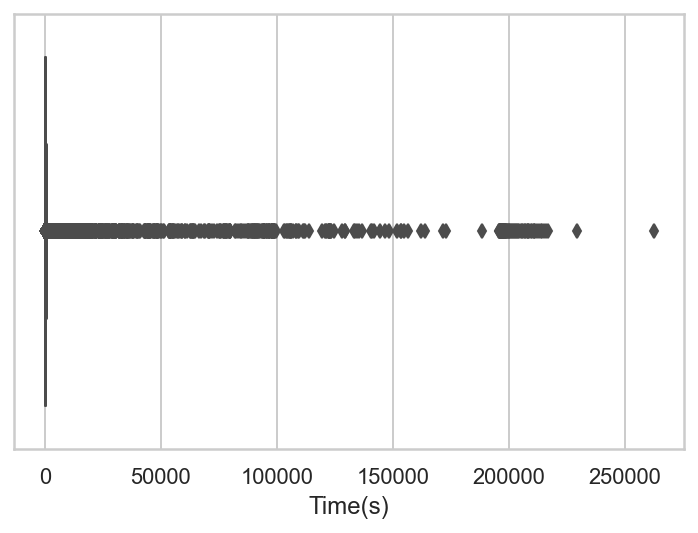

In [88]:
from plotly.subplots import make_subplots
time_limit=2*60
fig = make_subplots(rows=1, cols=2,subplot_titles=('Dataset 1', 'Dataset 2'),specs=[[{"type": "polar"}, {"type": "polar"}]],
                   )
fig1=calculateStarChart2(algs,"dataset1",time_limit,"Dataset 1",onlyResult=True,fileName="plots/dataset1_star.svg",legend=False,col=1)
fig2=calculateStarChart2(algs2,"dataset2",time_limit,"Dataset 2",onlyResult=True,fileName="plots/dataset2_star.svg",legend=True,col=2)

fig.layout=go.Layout(
            polar={'radialaxis': {'visible': True,'showticklabels':False,'range':[0, 1],'showline':False},
                   'angularaxis':{'rotation':90,},
                  },
    polar2={'radialaxis': {'visible': True,'showticklabels':False,'range':[0, 1],'showline':False},
                   'angularaxis':{'rotation':90,},
                  },
        
            showlegend=True,
            autosize=True,
            width=1000,
            #height=1500
        annotations=[
            {
                'text': 'Dataset 1',
                'y': 1.15,
                'x': 0.2,
                'font': {'size': 16},
                     'showarrow': False,
            },
            {
                'text': "Dataset 2",
                'y': 1.15,
                'x': 0.8,
                'font': {'size': 16},
                     'showarrow': False,
            },
            
        ]
        )


fig.update_layout(legend=dict(
        orientation="h",
        yanchor="bottom",
        xanchor="center",
        x=0.5
    ))

for f in fig1:
    fig.add_trace(f,row=1, col=1)
for f in fig2:
    fig.add_trace(f,row=1, col=2)

#print(fig)

pyo.plot(fig)
fig.write_image("plots/star.svg")

## Generate Dataset 1 Pareto comparison

Running...
Time:  67.58772850036621
AvgValue:  0.024240413507992654
NumSolutions:  35
HV:  1.0
Spread:  0.9281847805104517
Spacing:  0.43893397187667793
Time:  17.433212280273438
AvgValue:  0.02333728835986083
NumSolutions:  24
HV:  0.6010802977405967
Spread:  0.9041415671692881
Spacing:  0.32174062562490263


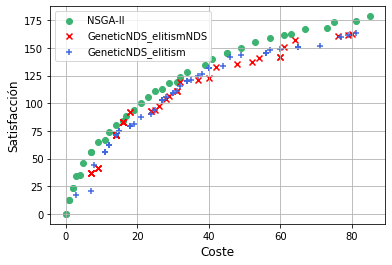

<Figure size 432x288 with 0 Axes>

In [1]:
from algorithms.genetic.genetic_algorithm import GeneticAlgorithm
from algorithms.nsgaii.nsgaii_algorithm import NSGAIIAlgorithm
from datasets.dataset1 import generate_dataset1_genes
from algorithms.genetic_nds.genetic_nds_algorithm import GeneticNDSAlgorithm
from datasets.dataset2 import generate_dataset2_genes
from models.problem import Problem
import matplotlib.pyplot as plt
import pandas as pd
# generar los genes de los requisitos------------------------------------------------------------------
genes=generate_dataset1_genes()
objectives_minimization=["MAX","MIN"]

# instanciar el problema------------------------------------------------------------------
problem=Problem(genes,objectives_minimization)

# crear seed random------------------------------------------------------------------
seed=54

# iniciar------------------------------------------------------------------
print("Running...")

algorithm=NSGAIIAlgorithm(problem,random_seed=seed,population_length=40,max_generations=300,crossover_prob=0.85,
						   crossover="onepoint",mutation_prob=1,mutation="flip1bit",replacement="elitism")

result=algorithm.run()
print("Time: ",result["time"])
print("AvgValue: ",result["avgValue"])
if "numSolutions" in result:
	print("NumSolutions: ",result["numSolutions"])
	print("HV: ",result["hv"])
	print("Spread: ",result["spread"])
	print("Spacing: ",result["spacing"])

func = [i.objectives for i in result["population"]]
function1 = [i[0].value for i in func]
function2 = [i[1].value for i in func]

algorithm=GeneticNDSAlgorithm(problem,random_seed=seed,population_length=30,max_generations=200,crossover_prob=0.9,
							 crossover="onepoint", mutation_prob=0.1,mutation="flip1bit",replacement="elitismnds")
result=algorithm.run()
print("Time: ",result["time"])
print("AvgValue: ",result["avgValue"])
if "numSolutions" in result:
	print("NumSolutions: ",result["numSolutions"])
	print("HV: ",result["hv"])
	print("Spread: ",result["spread"])
	print("Spacing: ",result["spacing"])
func = [i.objectives for i in result["population"]]
function3 = [i[0].value for i in func]
function4 = [i[1].value for i in func]


algorithm=GeneticNDSAlgorithm(problem,random_seed=seed,population_length=40,max_generations=200,crossover_prob=0.85,
							  crossover="onepoint", mutation_prob=0.1,mutation="flip1bit",replacement="elitism")
result=algorithm.run()
func = [i.objectives for i in result["population"]]
function5 = [i[0].value for i in func]
function6 = [i[1].value for i in func]

plt.xlabel('Coste', fontsize=12)
plt.ylabel('Satisfacción', fontsize=12)
plt.scatter(function2, function1, marker='o',label="NSGA-II",c="#3cb371")
plt.scatter(function4, function3, marker='x',label="GeneticNDS_elitismNDS",c="#ff0000")
plt.scatter(function6, function5, marker='+',label="GeneticNDS_elitism",c="#4169e1")
plt.legend(loc="upper left")
fig1 = plt.gcf()
plt.grid(True)
plt.show()
plt.draw()
fig1.savefig('plots/dataset1_pareto.svg', dpi=100)

## Generate Dataset 2 Pareto comparison

In [ ]:
from algorithms.genetic.genetic_algorithm import GeneticAlgorithm
from algorithms.nsgaii.nsgaii_algorithm import NSGAIIAlgorithm
from dataset1 import generate_dataset1_genes
from algorithms.genetic_nds.genetic_nds_algorithm import GeneticNDSAlgorithm
from dataset2 import generate_dataset2_genes
from models.problem import Problem
import matplotlib.pyplot as plt
import pandas as pd
# generar los genes de los requisitos------------------------------------------------------------------
genes=generate_dataset2_genes()
objectives_minimization=["MAX","MIN"]

# instanciar el problema------------------------------------------------------------------
problem=Problem(genes,objectives_minimization)

# crear seed random------------------------------------------------------------------
seed=54

# iniciar------------------------------------------------------------------
print("Running...")

algorithm=NSGAIIAlgorithm(problem,random_seed=seed,population_length=30,max_generations=200,crossover_prob=0.6,
						   crossover="onepoint",mutation_prob=0.05,mutation="flipeachbit",replacement="elitism")

result=algorithm.run()
print("Time: ",result["time"])
print("AvgValue: ",result["avgValue"])
if "numSolutions" in result:
	print("NumSolutions: ",result["numSolutions"])
	print("HV: ",result["hv"])
	print("Spread: ",result["spread"])
	print("Spacing: ",result["spacing"])

func = [i.objectives for i in result["population"]]
function1 = [i[0].value for i in func]
function2 = [i[1].value for i in func]

algorithm=GeneticNDSAlgorithm(problem,random_seed=seed,population_length=20,max_generations=100,crossover_prob=0.6,
							 crossover="onepoint", mutation_prob=0.7,mutation="flip1bit",replacement="elitismnds")
result=algorithm.run()
print("Time: ",result["time"])
print("AvgValue: ",result["avgValue"])
if "numSolutions" in result:
	print("NumSolutions: ",result["numSolutions"])
	print("HV: ",result["hv"])
	print("Spread: ",result["spread"])
	print("Spacing: ",result["spacing"])
func = [i.objectives for i in result["population"]]
function3 = [i[0].value for i in func]
function4 = [i[1].value for i in func]


algorithm=GeneticNDSAlgorithm(problem,random_seed=seed,population_length=20,max_generations=200,crossover_prob=0.9,
							  crossover="onepoint", mutation_prob=0.7,mutation="flip1bit",replacement="elitism")
result=algorithm.run()
func = [i.objectives for i in result["population"]]
function5 = [i[0].value for i in func]
function6 = [i[1].value for i in func]

plt.xlabel('Coste', fontsize=12)
plt.ylabel('Satisfacción', fontsize=12)
plt.scatter(function2, function1, marker='o',label="NSGA-II",c="#3cb371")
plt.scatter(function4, function3, marker='x',label="GeneticNDS_elitismNDS",c="#ff0000")
plt.scatter(function6, function5, marker='+',label="GeneticNDS_elitism",c="#4169e1")
plt.legend(loc="upper left")
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('plots/dataset2_pareto.svg', dpi=100)